# Word Embedding (RNN-LSTM Model)
Disclaimer: As the flow of the data preparation are similar to the baseline file, we will not be further explaining repeated concepts except models generated or when necessary.

This file aims to generate a suitable model for word embedded features. Hence, the focus of this file is to create a model of obtainable standards for comparison among the various other models (present in other files). The comparison of the models and other classifiers will be shown and elaborated in the report itself. As mentioned in the report, the 3 tsv files will not be concatenated (and split again) to ensure a balanced training, validation and test dataset to a certain extent. This ensures more accurate and efficient machine learning techniques to obtain results.

In [1]:
pip install scikit-multilearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [4]:
#required libraries imported to run project
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import emoji
import re
import json
import nltk
import seaborn as sns
import skmultilearn
from keras_tuner.tuners import Hyperband
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras import Input
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.multioutput import MultiOutputClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report,confusion_matrix,balanced_accuracy_score,cohen_kappa_score,roc_auc_score

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_map = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [7]:
def contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    return text

def clean_text(text, remove_stopwords=True):
    text = emoji.demojize(text)
    text = text.lower()

    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    text = contractions(text, contractions_map)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string 

    # remove stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
    
    # Lemmatize each token
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    words = [*map(''.join, text)]
    full_test = [*map(''.join, words)]
    return full_test

In [8]:
train_df = pd.read_csv("dataset/train.tsv",sep='\t')
val_df = pd.read_csv("dataset/dev.tsv",sep='\t')
test_df = pd.read_csv("dataset/test.tsv",sep='\t')

In [9]:
train_df['List of classes'] = train_df['emotion'].apply(lambda x: x.split(','))
val_df['List of classes'] = val_df['emotion'].apply(lambda x: x.split(','))
test_df['List of classes'] = test_df['emotion'].apply(lambda x: x.split(','))

In [10]:
with open('dataset/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [11]:
emotion_file = open("dataset/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [12]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

train_df['Emotions'] = train_df['List of classes'].apply(idx2class)
val_df['Emotions'] = val_df['List of classes'].apply(idx2class)
test_df['Emotions'] = test_df['List of classes'].apply(idx2class)

In [13]:
train_df['Mapped Emotions'] = train_df['Emotions'].apply(EmotionMapping)
val_df['Mapped Emotions'] = val_df['Emotions'].apply(EmotionMapping)
test_df['Mapped Emotions'] = test_df['Emotions'].apply(EmotionMapping)

In [14]:
one_hot = MultiLabelBinarizer()
y = pd.DataFrame(one_hot.fit_transform(train_df['Mapped Emotions']), columns=one_hot.classes_)
train_df = train_df.join(y)

y = pd.DataFrame(one_hot.fit_transform(val_df['Mapped Emotions']), columns=one_hot.classes_)
val_df = val_df.join(y)

y = pd.DataFrame(one_hot.fit_transform(test_df['Mapped Emotions']), columns=one_hot.classes_)
test_df = test_df.join(y)

In [15]:
#drop any columns that we will not be using
train_df = train_df.drop(train_df[train_df.neutral == 1].index)
train_df.drop(['neutral'], axis=1, inplace =True)
train_df=train_df.reset_index(drop=True)

val_df = val_df.drop(val_df[val_df.neutral == 1].index)
val_df.drop(['neutral'], axis=1, inplace =True)
val_df=val_df.reset_index(drop=True)

test_df = test_df.drop(test_df[test_df.neutral == 1].index)
test_df.drop(['neutral'], axis=1, inplace =True)
test_df=test_df.reset_index(drop=True)

In [16]:
train_df.drop(['emotion', 'id','List of classes', 'Emotions','Mapped Emotions'], axis=1, inplace=True)
val_df.drop(['emotion', 'id','List of classes', 'Emotions','Mapped Emotions'], axis=1, inplace=True)
test_df.drop(['emotion', 'id','List of classes', 'Emotions','Mapped Emotions'], axis=1, inplace=True)

In [17]:
#generate cleaned words and text - train data
train_df['words'] = train_df.text.apply(clean_text)
temp=list(train_df['words'])
train_df['filtered'] = [*map(' '.join, temp)]

#generate cleaned words and text - val data
val_df['words'] = val_df.text.apply(clean_text)
temp=list(val_df['words'])
val_df['filtered'] = [*map(' '.join, temp)]

#generate cleaned words and text - test data
test_df['words'] = test_df.text.apply(clean_text)
temp=list(test_df['words'])
test_df['filtered'] = [*map(' '.join, temp)]

In [18]:
dataset=pd.concat([train_df,val_df, test_df], axis=0)
dataset = dataset.reset_index(drop=True)

### Create functions to plot the accuracy and loss graphs

#### Loss VS Accuracy
We have functions that perform the action of plotting of loss and accuracy to be used later in the project when building a model. This is because we would be analysing both graphs to ensure that the model is performing as accurately as possible.

We would be using accuracy as our metrics at compilation as we can assume the dataset is balanced due to the used of a pre-selected training dataset. This is because accuracy is affected by the number of samples available. However, in this case as the dataset is still multi-label we will take into consideration other factors to ensure optimal results when creating models as accuracy would only show the performace of the classifier at guessing. We should be using 'scoring rules' such as "loss functions that map predicted probabilities and corresponding observed outcomes to loss values, which are minimized in expectation by the true probabilities (p,1−p)".

Hence, in order to ensure optimal performance of the model. We would plot both accuracy and loss graphs when building and improving on our models to ensure that the model is underfit/overfit/goodfit.

In [19]:
def plot_accuracy(acc, val_acc):
    '''plot training accuracy and validation accuracy'''
    plt.clf() #clear any existing figures
    epochs = range(1, len(acc)+1) #get a number of epochs
    #assign values for each axis
    plt.plot(epochs, acc, 'bo', label="Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
    #set a title of graph and labels of each axis
    plt.title("Training and validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_loss(loss, val_loss):
    '''plot training loss and validation loss on the graph'''
    plt.clf() #clear any existing figures
    epochs = range(1, len(loss)+1) #get a number of epochs
    #assign values for each axis
    plt.plot(epochs, loss, 'bo', label="Loss")
    plt.plot(epochs, val_loss, 'b', label="validation loss")
    #set a title of graph and labels of each axis
    plt.title("Training Loss & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Word Embedding
Using Word2Vec, we train a word2vec model and obtain the vocab size of the entire dataset. Following which, tokenizing and padding of sequences are perform to ensure that all vectors are of the same size (300). The embedding matrix acts as the weights in the Embedding layer.

In [20]:
#emotion labels - 6 labels
col = ['anger','disgust','fear','joy','sadness', 'surprise']

y_train = train_df[col]
y_val = val_df[col]
y_test = test_df[col]

print("Y train shape: ",y_train.shape)
print("Y test shape: ",y_test.shape)
print("Y val shape: ",y_val.shape)

Y train shape:  (29191, 6)
Y test shape:  (3640, 6)
Y val shape:  (3660, 6)


In [21]:
w2v_model = Word2Vec(dataset.words, min_count=1,size=300, iter=100)
pretrained_weights = w2v_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print(pretrained_weights.shape)

(22852, 300)


C:\Users\REIPOT~1\AppData\Local\Temp/ipykernel_28408/1839708558.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  pretrained_weights = w2v_model.wv.syn0


In [22]:
vocab=w2v_model.wv.vocab
print("The total number of words are : ",len(vocab))
vocab=list(vocab.keys())

The total number of words are :  22852


In [23]:
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  22852


In [24]:
max_lenth=-1
for i,rev in enumerate(dataset.filtered):
    tokens=rev.split()
    if(len(tokens)>max_lenth):
        max_lenth=len(tokens)
print(max_lenth)

68


In [25]:
tok = Tokenizer()
tok.fit_on_texts(dataset.filtered)
vocab_size = len(tok.word_index) + 1

encd_train = tok.texts_to_sequences(train_df.filtered)
encd_val = tok.texts_to_sequences(val_df.filtered)
encd_test = tok.texts_to_sequences(test_df.filtered)

In [26]:
pad_train= pad_sequences(encd_train, maxlen=max_lenth, padding='post')
pad_val= pad_sequences(encd_val, maxlen=max_lenth, padding='post')
pad_test= pad_sequences(encd_test, maxlen=max_lenth, padding='post')

In [27]:
embed_matrix=np.zeros(shape=(vocab_size,emdedding_size))
for word,i in tok.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector

In [159]:
print('train_text', pad_train.shape)
print('train_labels', y_train.shape)
print('val_text', pad_val.shape)
print('val_labels', y_val.shape)
print('test_text', pad_test.shape)
print('test_labels', y_test.shape)

train_text (29191, 68)
train_labels (29191, 6)
val_text (3660, 68)
val_labels (3660, 6)
test_text (3640, 68)
test_labels (3640, 6)


### Underfit Model
The first model would be fairly simple, having the minimum requirements that we need to have statistical power. Which is to have an accuracy higher than 16.67. Our model will only have the required last activation layer sigmoid and the loss function binary_crossentropy.

In [113]:
model_word_underfit=Sequential()
model_word_underfit.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size ,input_length=max_lenth, weights=[embed_matrix],trainable=False))
model_word_underfit.add(LSTM(12))
model_word_underfit.add(Dense(6, activation='sigmoid'))

model_word_underfit.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history_model_word_underfit = model_word_underfit.fit(pad_train, y_train,epochs=10,batch_size=256,validation_data = (pad_val, y_val), verbose=0)

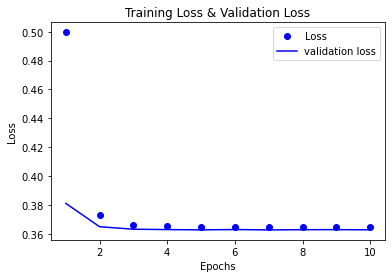

In [114]:
plot_loss(history_model_word_underfit.history['loss'], history_model_word_underfit.history['val_loss'])

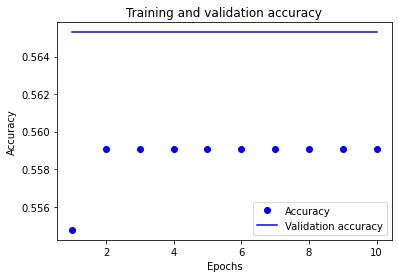

In [115]:
plot_accuracy(history_model_word_underfit.history['accuracy'], history_model_word_underfit.history['val_accuracy'])

### Overfit Model
After developing a model that is able to do better than the baseline, we need to develop a model that overfits. As the aim of this project is to create a model that stands on the line between overfitting and underfitting, we now need to cross the line to develop a model that overfits.

Here, we would be making the model bigger or increasing the training until the model's performance on the validation data starts degrading. This is when overfitting has been achieved.

In [117]:
model_word_overfit=Sequential()
model_word_overfit.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size ,input_length=max_lenth, weights=[embed_matrix],trainable=False))
model_word_overfit.add(LSTM(12, return_sequences=True))
model_word_overfit.add(LSTM(12))
model_word_overfit.add(Dense(12, activation='relu'))
model_word_overfit.add(Dense(6, activation='relu'))
model_word_overfit.add(Dense(6, activation='sigmoid'))

model_word_overfit.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history_model_word_overfit = model_word_overfit.fit(pad_train, y_train,epochs=15,batch_size=32,validation_data = (pad_val, y_val), verbose=0)

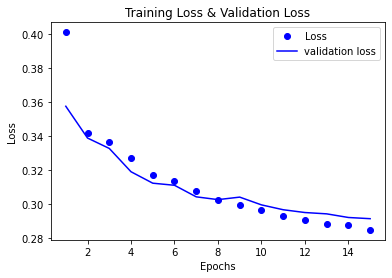

In [118]:
plot_loss(history_model_word_overfit.history['loss'], history_model_word_overfit.history['val_loss'])

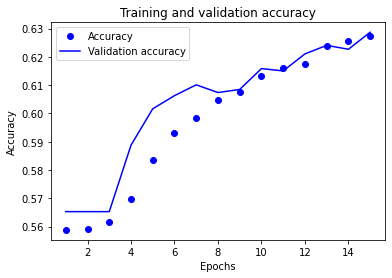

In [119]:
plot_accuracy(history_model_word_overfit.history['accuracy'], history_model_word_overfit.history['val_accuracy'])

### Good Model
After creating a model that overfits, we need to modify the model until the line we mentioned above, is found. This can be done using various methods such as tuning the hyper-parameters.

When the model is initialised, we will evaluate the network on the complete test set.

In [137]:
model_word_goodfit=Sequential()
model_word_goodfit.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size ,input_length=max_lenth, weights=[embed_matrix],trainable=False))
model_word_goodfit.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.L1(0.0003)))
model_word_goodfit.add(LSTM(64, kernel_regularizer=regularizers.L1(0.0003)))
model_word_goodfit.add(Dense(6, activation='relu', kernel_regularizer=regularizers.L1(0.0003)))
model_word_goodfit.add(Dense(6, activation='sigmoid'))

model_word_goodfit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
history_model_word_overfit = model_word_goodfit.fit(pad_train, y_train,epochs=20,batch_size=128,validation_data = (pad_val, y_val), verbose=0)

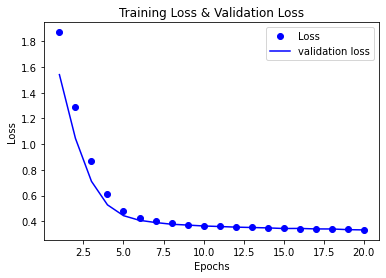

In [138]:
plot_loss(history_model_word_overfit.history['loss'], history_model_word_overfit.history['val_loss'])

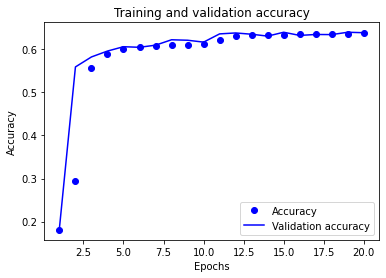

In [139]:
plot_accuracy(history_model_word_overfit.history['accuracy'], history_model_word_overfit.history['val_accuracy'])

We evaluate the good-fit model to obtain results of loss and accuracy.

In [140]:
test_loss, test_acc = model_word_goodfit.evaluate(pad_test, y_test)

114/114 [==============================] - 4s 36ms/step - loss: 0.3381 - accuracy: 0.6277


### Running hyper tuning based on Good Model
Although we have managed to generate a goodfit model of satisfactory standards, at 62% accuracy which is better than a naive guess of 16.6% accuracy (at best). We will attempt to achieve better accuracy, by using Hyperband from the keras library to perform automated hyper parameter tuning.

Below we create a function to build our model, this helps define the hyperparameter search space and the model architecture.

In [142]:
def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size ,input_length=max_lenth, weights=[embed_matrix],trainable=False))

    model.add(LSTM(units=hp.Choice('lstm1_layer', values=[16,32,64,128,256,512]), return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.L1(hp.Float('dense1_L1', min_value=0.00001, max_value=0.001))))
    model.add(LSTM(units=hp.Choice('lstm2_layer', values=[16,32,64,128,256,512]),
                   kernel_regularizer=tf.keras.regularizers.L1(hp.Float('dense2_L1', min_value=0.00001, max_value=0.001))))
    model.add(Dense(units=hp.Choice('dense1_layer', values=[16,32,64,128,256,512]), activation = 'relu',
                   kernel_regularizer=tf.keras.regularizers.L1(hp.Float('dense2_L1', min_value=0.00001, max_value=0.001))))
   
    model.add(Dense(6, activation = 'sigmoid'))
    tf.random.set_seed(2)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='binary_crossentropy', metrics=['accuracy'])
    return model

Instantiate the Hyperband tuner and perform hypertuning

In [143]:
tuner = Hyperband(
    hypermodel=model_builder,
    max_epochs=30,
    objective='val_accuracy',
    factor=3,
    directory='LSTM_word_models/',
    project_name='word_lstm'
)

In [144]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
lstm1_layer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
dense1_L1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': None}
lstm2_layer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
dense2_L1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': None}
dense1_layer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}


We use a callback called EarlyStopping to stop the training when validation loss has reached a certain value, or when no improvements are made for 5 epochs.

In [145]:
tuner.search(pad_train, y_train, epochs = 30, validation_data = (pad_val,y_val), batch_size= 128, callbacks = [EarlyStopping(monitor='val_loss', patience=5)])

Trial 90 Complete [00h 19m 31s]
val_accuracy: 0.5653005242347717

Best val_accuracy So Far: 0.616939902305603
Total elapsed time: 1d 21h 44m 33s
INFO:tensorflow:Oracle triggered exit


In [147]:
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'learning_rate': 0.0001, 'lstm1_layer': 256, 'dense1_L1': 0.0007118660988822876, 'lstm2_layer': 256, 'dense2_L1': 0.0009007521412954627, 'dense1_layer': 256, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0076'}


Build the model with the optimal hyper-parameters and obtain the optimal number of epochs to train the model.

In [148]:
best_model_tuner = tuner.hypermodel.build(best_hps)
histry_best_tunder =best_model_tuner.fit(pad_train, y_train, epochs=30, validation_data=(pad_val,y_val), batch_size= 128, verbose=0)
tf.random.set_seed(2)
val_acc_per_epoch = histry_best_tunder.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 30


We retrain the hyper-tuned model using the best epochs and evaluate to obtain the loss and accuracy results.

In [149]:
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
history=hypermodel.fit(pad_train, y_train, epochs=best_epoch, validation_data=(pad_val,y_val), batch_size= 128, verbose=0)

In [151]:
eval_result = hypermodel.evaluate(pad_test, y_test)
print("[test loss, test accuracy]:", eval_result)

114/114 [==============================] - 28s 243ms/step - loss: 0.3329 - accuracy: 0.6071
[test loss, test accuracy]: [0.3329086899757385, 0.6071428656578064]


### Training models on full train data
Now that we have the final models/networks, we will perform the training on the complete training set instead of the partial training set. Hence, we have concatenated both the training and validation text and labels below. In addition, the evaluation function generates a table to compare the metrics of the manually tuned model and the hyper-tuned model by keras Hyperband.

In [152]:
summary_table = PrettyTable(["Loss","Accuracy","Precision","Recall","F1","Cohen Kappa","Model"])

def evaluation (x_test, y_test,x_val, y_val,model,model_name):
    test_loss, test_acc = model.evaluate(x_val, y_val)
    
    y_pred = model.predict(x_test)
    Y_test=y_test.values.argmax(axis=1)
    Y_pred = np.argmax(y_pred,axis=1)

    cm = confusion_matrix(Y_test, Y_pred)
    p = precision_score(Y_test, Y_pred, average='weighted')
    r = recall_score(Y_test, Y_pred, average='weighted')
    f = f1_score(Y_test,Y_pred, average='weighted')
    ck = cohen_kappa_score(Y_test, Y_pred)
    
    values = [test_loss,test_acc,p,r,f,ck]
    rounded_row = [round(elem, 3) for elem in values]
    rounded_row.append(model_name)
    
    summary_table.add_row(rounded_row)

### Manually-tuned model

In [153]:
model_word_goodfit=Sequential()
model_word_goodfit.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size ,input_length=max_lenth, weights=[embed_matrix],trainable=False))
model_word_goodfit.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.L1(0.0003)))
model_word_goodfit.add(LSTM(64, kernel_regularizer=regularizers.L1(0.0003)))
model_word_goodfit.add(Dense(6, activation='relu', kernel_regularizer=regularizers.L1(0.0003)))
model_word_goodfit.add(Dense(6, activation='sigmoid'))
model_word_goodfit.summary()

model_word_goodfit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 68, 300)           6855900   
                                                                 
 lstm_6 (LSTM)               (None, 68, 64)            93440     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 6,982,796
Trainable params: 126,896
Non-trainable params: 6,855,900
_________________________________________________________________


In [155]:
#training on full dataset
final_fit = model_word_goodfit.fit(np.concatenate([pad_train,pad_val]),np.concatenate([y_train,y_val]), epochs=20, batch_size=128, verbose=0)
evaluation (pad_test, y_test,pad_val, y_val,model_word_goodfit,'manual-tuned model')

115/115 [==============================] - 7s 54ms/step - loss: 0.3454 - accuracy: 0.6342


C:\Users\ReiPotato\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Hyper-tuned Model (Automated HyperBand)

In [156]:
hypermodel = tuner.hypermodel.build(best_hps)
tf.random.set_seed(2)
hypermodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 68, 300)           6855900   
                                                                 
 lstm_8 (LSTM)               (None, 68, 256)           570368    
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 8,018,914
Trainable params: 1,163,014
Non-trainable params: 6,855,900
_________________________________________________________________


In [157]:
#training on full dataset
final_fit = hypermodel.fit(np.concatenate([pad_train,pad_val]),np.concatenate([y_train,y_val]), epochs=best_epoch, batch_size=128, verbose=0)
evaluation (pad_test, y_test,pad_val, y_val,hypermodel,'hyper-tuned model')

115/115 [==============================] - 29s 248ms/step - loss: 0.3692 - accuracy: 0.5653


C:\Users\ReiPotato\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the evaluation metrics below, we can say that both models are able to perform generally decent as they have higher accuracy than a naive guess of 16.6%. Comparing both models, the manual-tuned model is able generate better metric results and will be the most suitable representation model when used with Word-Embedding RNN-LSTM.

In [158]:
print(summary_table)

+-------+----------+-----------+--------+-------+-------------+--------------------+
|  Loss | Accuracy | Precision | Recall |   F1  | Cohen Kappa |       Model        |
+-------+----------+-----------+--------+-------+-------------+--------------------+
| 0.345 |  0.634   |   0.457   | 0.611  | 0.522 |    0.308    | manual-tuned model |
| 0.369 |  0.565   |   0.296   | 0.544  | 0.383 |     0.0     | hyper-tuned model  |
+-------+----------+-----------+--------+-------+-------------+--------------------+
